# Предсказание спутниковых снимков на основе карт-схем Google


В данной работе будет преобразовывать схемы Google карт в спутниковые снимки на основе данных, собранных с помощью Google Maps API.

В качестве примера, используем официальную [инструкцию Pix2Pix от Tensorflow](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb).

## Используемые библиотеки

In [1]:
import os
import shutil
from IPython import display
import time
import requests

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PROJECT_FOLDER = '/content/drive/My Drive/Colab Notebooks/Computer_vision/Project'
API_URL = 'https://maps.googleapis.com/maps/api/staticmap'
KEY = '*******************************************'  # Укажите ваш ключ API

## Скачиваем карты Москвы с использованием Google Maps API
Карты будем сохранять в папки roadmap и satellite.

In [4]:
def downloadPair(city, alt, lng, zoom, w, h):

    def saveMap(maptype):
        path = os.path.join(PROJECT_FOLDER, city, maptype, f'{zoom}_{w}x{h}_{alt}_{lng}.png')
        if not os.path.isfile(path):
            r = requests.get(API_URL, params)
            with open(path, 'wb') as f:
                f.write(r.content)

    params = {
      'center': f'{alt}, {lng}',
      'zoom': str(zoom),
      'size': f'{w}x{h+34}',
      'style': 'feature:all|element:labels|visibility:off',
      'key': KEY
    }

    saveMap('roadmap')
    params['maptype'] = 'satellite'
    saveMap('satellite')

Скачивать будем образцы карты между крайними точками с координатами `55.784, 37.571` и `55.712,37.690`.

In [29]:
def download_city(city, min_alt, max_alt, alt_step, min_lng, max_lng, lng_step):
    if not os.path.isdir(os.path.join(PROJECT_FOLDER, city)):
        os.mkdir(os.path.join(PROJECT_FOLDER, city))
    if not os.path.isdir(os.path.join(PROJECT_FOLDER, city, 'roadmap')):
        os.mkdir(os.path.join(PROJECT_FOLDER, city, 'roadmap'))
    if not os.path.isdir(os.path.join(PROJECT_FOLDER, city, 'satellite')):
        os.mkdir(os.path.join(PROJECT_FOLDER, city, 'satellite'))

    cnt = 0

    for alt in np.arange(min_alt, max_alt, alt_step):
        for lng in np.arange(min_lng, max_lng, lng_step):
            downloadPair(city, alt, lng, 18, 400, 400)
            cnt += 1
            if cnt % 100 == 0:
                print('.', end='')
            time.sleep(.005)
    print(f'\n{city} downloaded!')

In [30]:
download_city('Moscow', 55.712, 55.784, .001, 37.571, 37.690, .002)

...........................................Moscow downloaded!


## Проверка загруженных данных

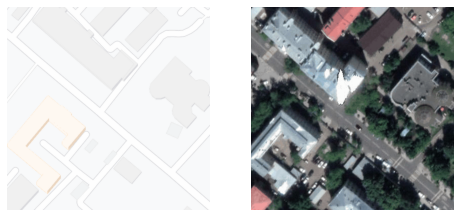

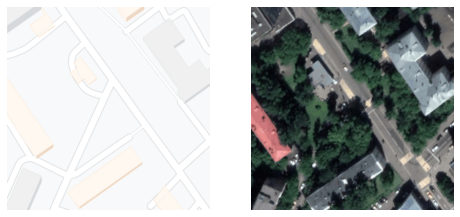

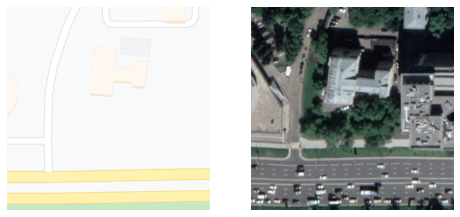

In [31]:
for _ in range(3):
    rand_im_name = np.random.choice(os.listdir(os.path.join(PROJECT_FOLDER, 'Moscow', 'roadmap')))
    im_roadmap = plt.imread(os.path.join(PROJECT_FOLDER, 'Moscow', 'roadmap', rand_im_name))
    im_satellite = plt.imread(os.path.join(PROJECT_FOLDER, 'Moscow', 'satellite', rand_im_name))

    fig = plt.figure(figsize=(8, 4))

    plt.subplot(121)
    plt.imshow(im_roadmap[:400, ...])
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(im_satellite[:400, ...])
    plt.axis('off')

    plt.show()

## Разбиваем на тренировочные и тестовые данные

In [6]:
CITY = 'Moscow'

for data_type in ['train', 'test']:
    if not os.path.isdir(os.path.join(PROJECT_FOLDER, CITY, data_type)):
        os.mkdir(os.path.join(PROJECT_FOLDER, CITY, data_type))
    if not os.path.isdir(os.path.join(PROJECT_FOLDER, CITY, data_type, 'roadmap')):
        os.mkdir(os.path.join(PROJECT_FOLDER, CITY, data_type, 'roadmap'))
    if not os.path.isdir(os.path.join(PROJECT_FOLDER, CITY, data_type, 'satellite')):
        os.mkdir(os.path.join(PROJECT_FOLDER, CITY, data_type, 'satellite'))

In [38]:
%%time
def copyf(im, data_type):
    for maptype in ['roadmap', 'satellite']:
        if not os.path.isfile(os.path.join(PROJECT_FOLDER, CITY, data_type, maptype, im)):
            shutil.copyfile(os.path.join(PROJECT_FOLDER, CITY, maptype, f), os.path.join(PROJECT_FOLDER, CITY, data_type, maptype, im))

files = os.listdir(os.path.join(PROJECT_FOLDER, CITY, 'roadmap'))
np.random.seed(21)
print(f'Всего примеров {len(files)}')
cnt = 0
for f in files:
    if np.random.rand(1) < 0.25:
        copyf(f, 'test')
    else:
        copyf(f, 'train')
    cnt += 1
    if cnt % 100 == 0:
        print('.', end='')
print()
print('Готово!')

Всего примеров 4320
...........................................
Готово!
CPU times: user 4.68 s, sys: 6.36 s, total: 11 s
Wall time: 39min 41s


Проверим количество изображений в каждой папке

In [7]:
len(os.listdir(os.path.join(PROJECT_FOLDER, CITY, 'train', 'roadmap')))

3223

In [8]:

len(os.listdir(os.path.join(PROJECT_FOLDER, CITY, 'test', 'roadmap')))

1097

## Пайплайн данных для обучения

In [50]:
BUFFER_SIZE = 2000
BATCH_SIZE = 16
IMG_SIZE = 256

In [51]:
def get_x_y_images(image_path):
    roadmap_image = tf.io.read_file(image_path)
    roadmap_image = tf.image.decode_png(roadmap_image)[:400, ...]
    roadmap_image = tf.cast(roadmap_image, tf.float32)
    roadmap_image = (roadmap_image / 127.5) - 1.
    roadmap_image = tf.image.resize(
        roadmap_image, 
        [IMG_SIZE, IMG_SIZE],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    image_path = tf.strings.regex_replace(image_path, "roadmap", "satellite")
    satellite_image = tf.io.read_file(image_path)
    satellite_image = tf.image.decode_png(satellite_image)[:400, ...]
    satellite_image = tf.cast(satellite_image, tf.float32) 
    satellite_image = (satellite_image / 127.5) - 1.
    satellite_image = tf.image.resize(
        satellite_image, 
        [256, 256],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
   
    return roadmap_image, satellite_image

In [52]:
train_dataset = tf.data.Dataset.list_files('/content/drive/My Drive/Colab Notebooks/Computer_vision/Project/Moscow/train/roadmap/*.png')
train_dataset = train_dataset.map(get_x_y_images,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [53]:
test_dataset = tf.data.Dataset.list_files('/content/drive/My Drive/Colab Notebooks/Computer_vision/Project/Moscow/test/roadmap/*.png')
test_dataset = test_dataset.map(get_x_y_images)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Строим генератор
 * Архитектура генератора - это модифицированная модель U-Net.
 * Каждый блок кодера (Conv -> Batchnorm -> Leaky ReLU)
 * Каждый блок декодера (Transposed Conv -> Batchnorm -> Dropout -> ReLU)
 * Между слоями кодера и декодера есть соединения как в U-Net.

In [54]:
OUTPUT_CHANNELS = 3

#### Нисходящее плечо

In [55]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

#### Восходящее плечо

In [56]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

#### Функция генератора

In [57]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    # Нисходящее плечо
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    # Восходящее плечо
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    # Выходной слой
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 3)

    # СВЯЗЫВАЕМ СЛОИ:
    x = inputs

    # 1) По нисходящему плечу
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  # список выходов с пропущенными соединениями (для конкатенации)

    # 2) По восходящему плечу с восстановлением пропущенных соединений
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

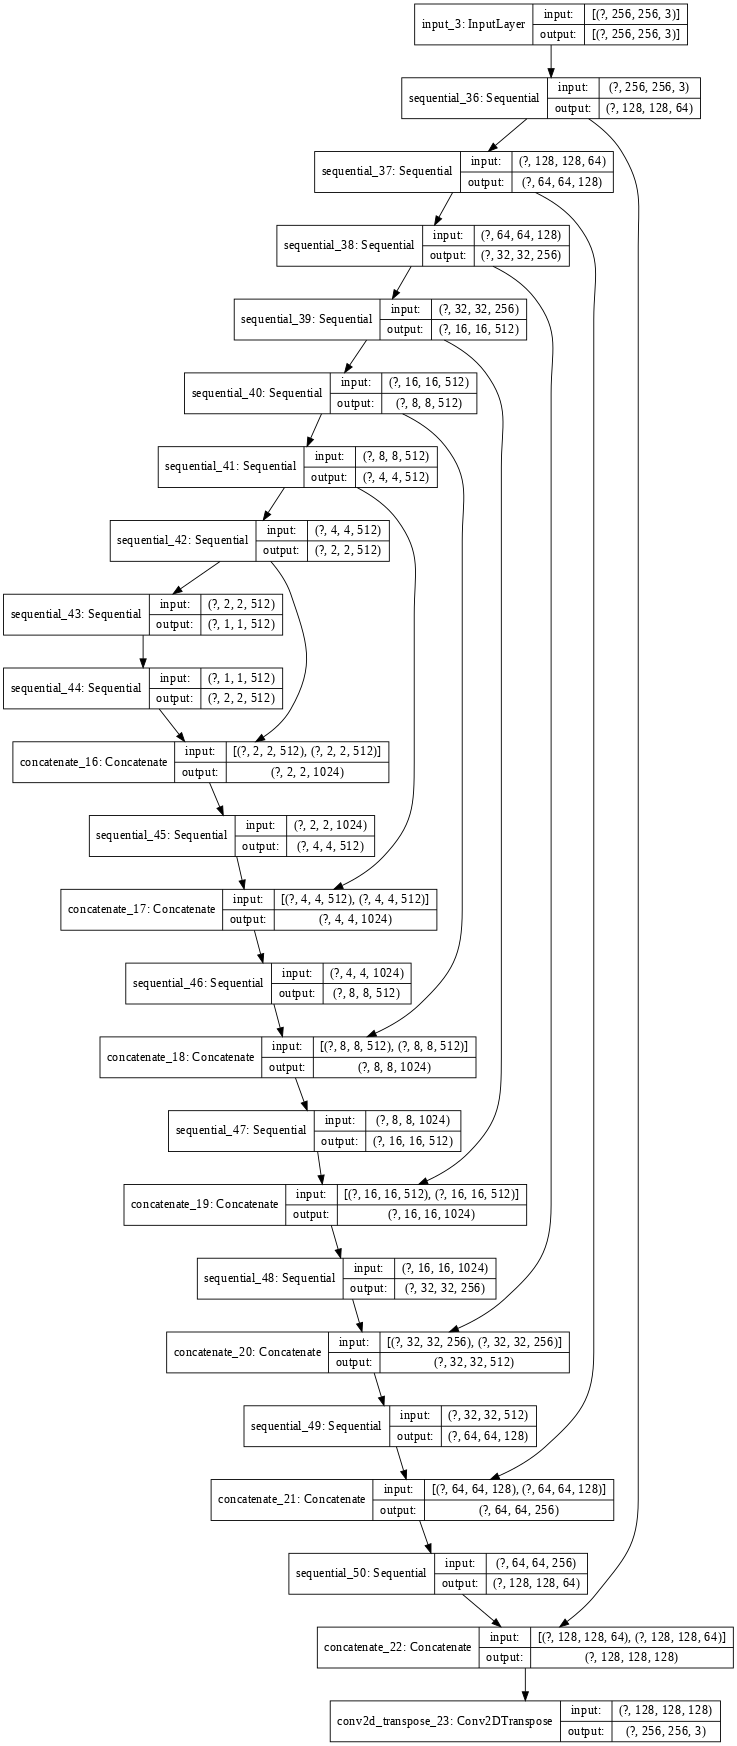

In [58]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

## Функция потерь генератора
 * Это сигмоидная кросс-энтропия генерируемых изображений и подобных по размерности единичных тензоров.
 * Также включена функция потерь `L1`, являющаяся `MAE` между генерируемым изображением и целевым изображением.
 * Это позволяет сгенерированному изображению стать похожим на целевое изображение.
 * Формула для расчета суммарных потерь генератора `gan_loss + LAMBDA * l1_loss`, где `LAMBDA = 100`. [Статья](https://arxiv.org/pdf/1611.07004.pdf).

In [59]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [60]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # MAE
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

#### Схема обучения генератора

![](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)

## Строим дискриминатор
 * Используется архитектура PatchGAN.
 * Каждый блок представляет из себя свертку с последующей нормализацию и функцией активацией ReLU после этого.
 * На выходе получаем размерность (<размер батча>, 30, 30, 1)
 * Каждый кусок (патч patch) 30x30 на выходе будет бинарно классифицироваться как реалилистичное или не реалистричное изображение (Как в PatchGAN).
 * Дискриминатор имеет 2 входа.
  * Входное изображение и целевое изоражение, которое будет классифицироваться как реалистичное.
  * Входное изображение и сгенерированное генератором изображение, которое будет классифицироваться как не реалистичное.

In [61]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    # Объединяем два входных слоя
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    # + сверточные слои
    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

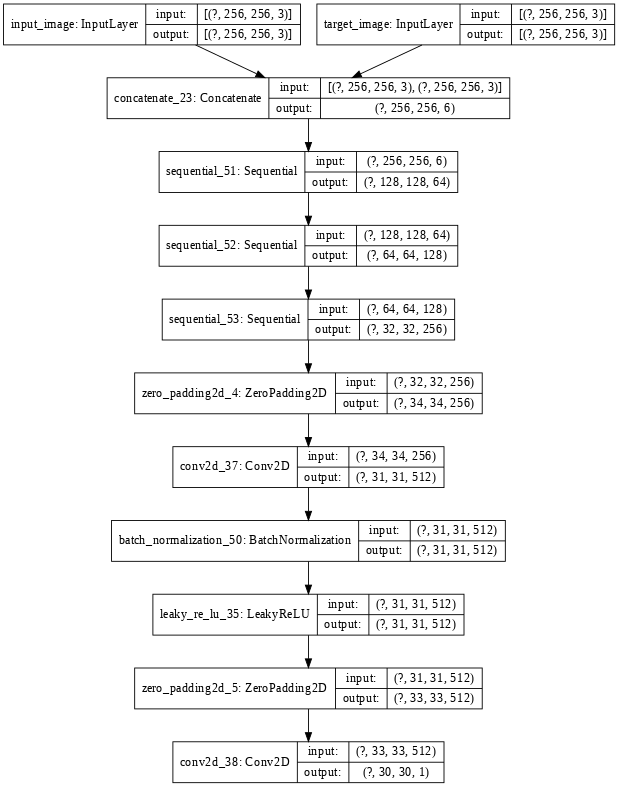

In [62]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

## Функция потерь дискриминатора

 * Функция потерь дискриминатора имеет 2 входа, а именно: настоящие изображения, сгенерированные изображения
 * real_loss = сигмоидная кросс энтропия настоящего изображения и нулевого тензора
 * generated_loss = сигмоидная кросс энтропия сгенерированного изображения и нулевого тензора
 * total_loss = real_loss + generated_loss

In [63]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

#### Cхема обучения дискриминатора

![](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)

In [64]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#### Checkpoint

In [65]:
ckpt = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    os.path.join(PROJECT_FOLDER, 'Moscow', 'training_checkpoints'), 
    max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


## Функция прямого хода (Inference)
 * Подаем на вход изображения из тестовой выборки
 * Трансформируем их с помощью генератора
 * Выводим Входное, Реальное и Предсказанное

In [66]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Входное изображение', 'Реальное изображение', 'Предсказанное изображение']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

## Функция обучения
 * Для каждого примера входной сигнал генерирует выходной сигнал.
 * Дискриминатор получает input_image и сгенерированное изображение в качестве первого входного сигнала. Второй вход - это input_image и target_image.
 * Рассчитываем потери генератора и дискриминатора
 * После этого считаем градиенты потерь как генератора, так и к дискриминанта (входным сигналам) и применяем к оптимизатору.

In [67]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], 
                                              training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

## Цикл обучения

 * Цикл по числу эпох.
 * В каждую эпоху запускается генерацию и вывод одного изображения для визуализации прогресса.
 * Каждую эпоху обрабатываем весь набор обучающих данных случайно разбитый на партии по 16 изображений (батчи). Чекпоинт сохраняем каждые 5 эпох.

In [68]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

        # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, 
                                                                 ckpt_save_path))

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                            time.time()-start))

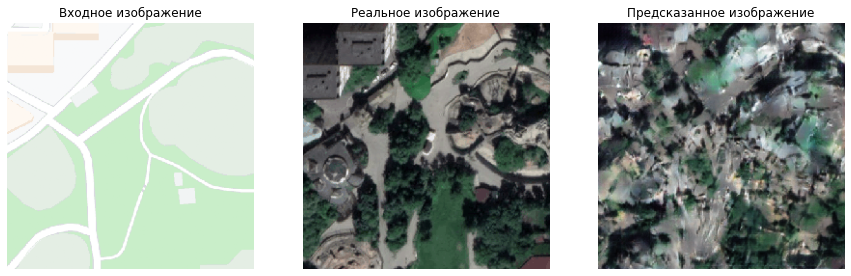

Epoch:  199
....................................................................................................
....................................................................................................
..
Saving checkpoint for epoch 200 at /content/drive/My Drive/Colab Notebooks/Computer_vision/Project/Moscow/training_checkpoints/ckpt-200
Time taken for epoch 200 is 54.17982578277588 sec



In [69]:
fit(train_dataset, 200, test_dataset)

## Проверка на тестовых данных

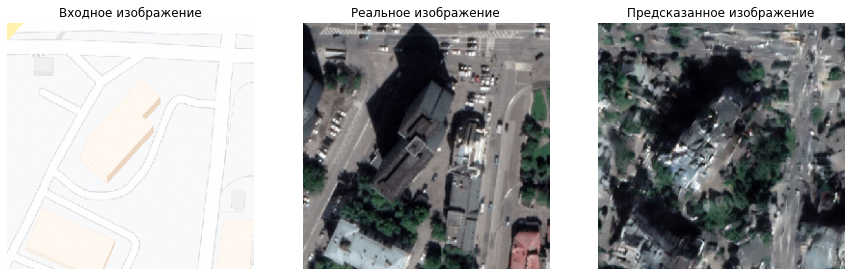

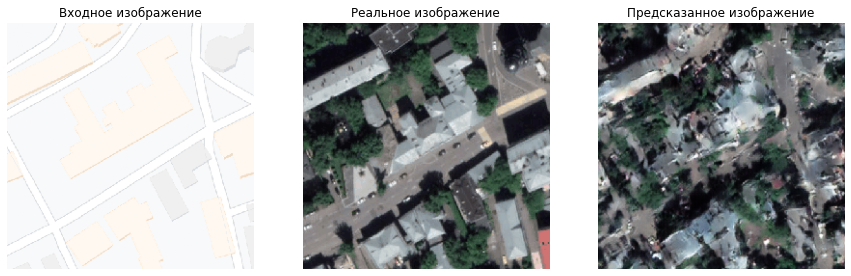

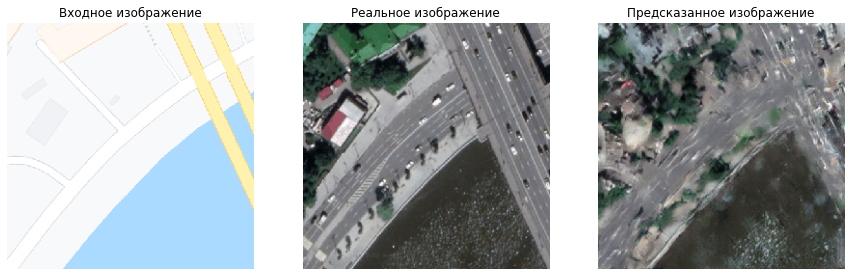

In [77]:
for roadmap, satellite in test_dataset.take(3):
    generate_images(generator, roadmap, satellite)

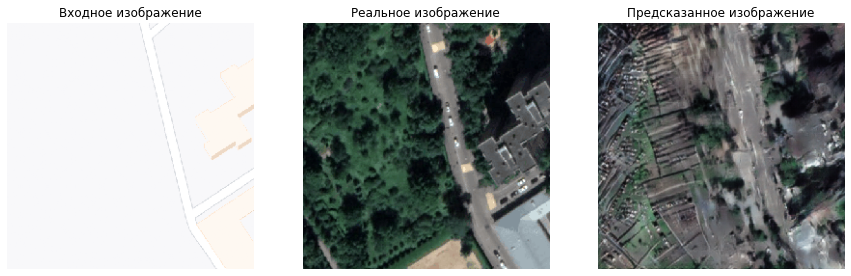

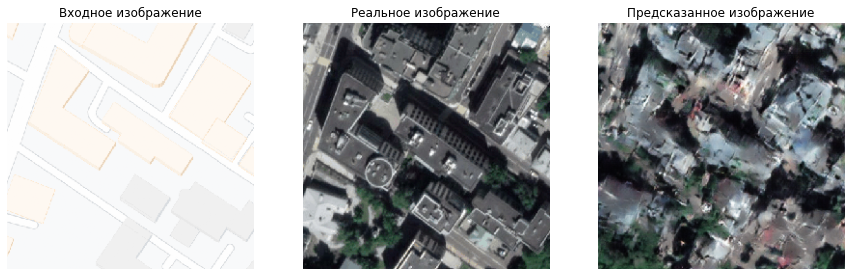

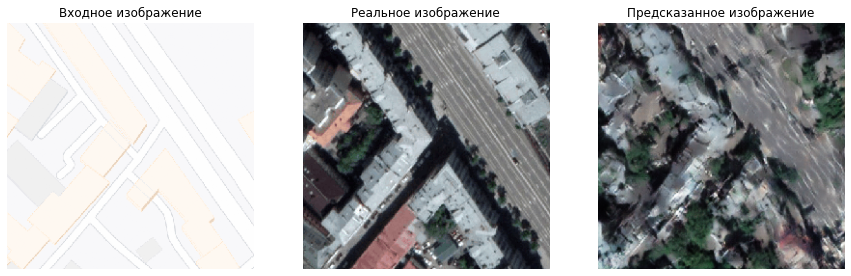

In [79]:
for roadmap, satellite in test_dataset.take(3):
    generate_images(generator, roadmap, satellite)

In [81]:
generator.save_weights(os.path.join(PROJECT_FOLDER, CITY, 'generator.hdf5'))